In [1]:
import os

import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl

np.random.seed(31337)

/home/denis/miniconda3/envs/lightfm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
wsl_train_path = "/mnt/c/Users/denis/PycharmProjects/recsys-course-spring-2025/hw/train.csv"
wsl_test_path = "/mnt/c/Users/denis/PycharmProjects/recsys-course-spring-2025/hw/test.csv"
train_data = pd.read_csv(wsl_train_path)
test_data = pd.read_csv(wsl_test_path)

In [55]:
user_id_map = {id: i for i, id in enumerate(train_data['user'].unique())}

In [56]:
train_data["user_id"] = train_data["user"].map(user_id_map).map(int)
test_data["user_id"] = test_data["user"].map(user_id_map).map(int)

In [58]:
users_id = sorted(set(train_data["user_id"]))
max_track_id = max(train_data['track'].max(), test_data['track'].max())
# tracks = sorted(all_tracks)

### Optuna

In [37]:
positives = train_data[train_data["time"] > 0.7].copy()
positives["validation"] = np.random.random(len(positives)) >= 0.8
# positives.drop_duplicates(["user", "track"], inplace=True)

# user_counts = positives_train[~positives_train["test"]].groupby("user").size()
# users = set(user_counts[user_counts >= 4].index.values)
# 
# track_counts = positives_train[~positives_train["test"]].groupby("track").size()
# tracks = set(track_counts[track_counts >= 4].index.values)

In [38]:
users = set(positives["user_id"].unique())
tracks = set(positives["track"].unique())

In [39]:
positives_train = positives[~positives["validation"]]
positives_val = positives[positives["validation"]]

In [40]:
# dataset = ld.Dataset()
# dataset.fit(users, tracks)
dataset = ld.Dataset()
dataset.fit(users_id, range(max_track_id + 1))

In [41]:
train_interactions, _ = dataset.build_interactions(positives_train[["user_id", "track"]].itertuples(index=False, name=None))
val_interactions, _ = dataset.build_interactions(positives_val[["user_id", "track"]].itertuples(index=False, name=None))

In [43]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, val_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopping!")
            break
        
    else:
        if verbose:
            print("No early stopping happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [30, 50, 80, 100, 120, 150])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=10, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
        threads=7
    )
    
    return precisions_at[-1]

In [44]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

[I 2025-03-18 18:47:58,279] A new study created in memory with name: no-name-9a2ccadd-90cf-413a-b173-5995265942b9
[I 2025-03-18 18:48:34,912] Trial 0 finished with value: 0.001551831024698913 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.001551831024698913.
[I 2025-03-18 18:49:41,467] Trial 1 finished with value: 0.00020691081590484828 and parameters: {'loss': 'bpr', 'no_components': 100, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.001551831024698913.
[I 2025-03-18 18:51:06,509] Trial 2 finished with value: 0.007521208841353655 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 2 with value: 0.007521208841353655.
[I 2025-03-18 18:51:47,171] Trial 3 finished with value: 0.0014483758714050055 and

In [47]:
best_params = study.best_params
best_params

{'loss': 'warp',
 'no_components': 150,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.0001,
 'item_alpha': 0.0001}

In [49]:
best_params = {'loss': 'warp',
 'no_components': 150,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.0001,
 'item_alpha': 0.0001
}

In [50]:
model, precisions_at = fit_model(
    epochs=500,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"],
    learning_rate=best_params["learning_rate"],
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
    patience=5,
)

0:	0.0015311400638893247 +/- 0.00026262869442133033
1:	0.0015828678151592612 +/- 0.0002679333443317292
2:	0.001738051068969071 +/- 0.0002889784574931553
3:	0.002151872729882598 +/- 0.00032793486146852655
4:	0.003527829423546791 +/- 0.00042679463943705477
5:	0.005452099721878767 +/- 0.0005373818732389806
6:	0.0072936066426336765 +/- 0.0006182657856955723
7:	0.009631698951125145 +/- 0.0006856734525534442
8:	0.01237326767295599 +/- 0.0007705799342360225
9:	0.015683839097619057 +/- 0.0008522279744299707
10:	0.018642665818333626 +/- 0.0009230661581936615
11:	0.020887648686766624 +/- 0.0009799435818908984
12:	0.023205049335956573 +/- 0.0010269138581332463
13:	0.02533623017370701 +/- 0.0010704404723041122
14:	0.026877714321017265 +/- 0.0010983502583343369
15:	0.0285019688308239 +/- 0.001123896142539306
16:	0.02970205247402191 +/- 0.0011446479774001371
17:	0.030850404873490334 +/- 0.0011592457952691998
18:	0.0318332314491272 +/- 0.0011760530407003535
19:	0.03261949121952057 +/- 0.0011873652355

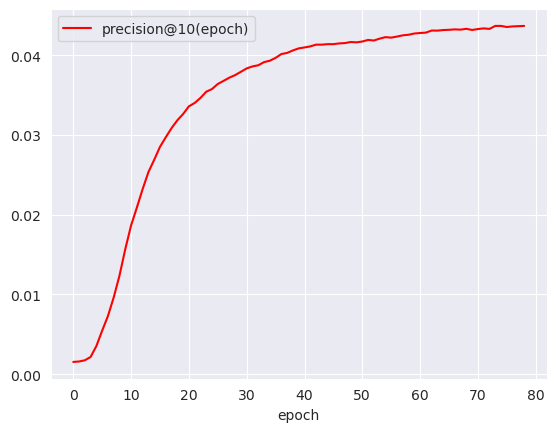

In [51]:
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

In [52]:
test_data["score"] = model.predict(test_data["user_id"].values, test_data["track"].values)
test_data[["user", "track", "score"]].to_csv("test_lfm_3_after_optuna_150.csv", index=False)

ValueError: The item feature matrix specifies more features than there are estimated feature embeddings: 43862 vs 50000.

In [ ]:
from sklearn.model_selection import KFold

def fit_model_with_cv(
    positives,
    epochs=1,
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01,
    max_sampled=10,
    user_alpha=0.0,
    item_alpha=0.0,
    threads=30,
    verbose=False,
    patience=3,
    epsilon=1e-6,
    n_splits=5
):
    # users_id = sorted(set(train_data["user_id"]))
    # tracks = set(positives["track"].unique())
    
    # dataset = lightfm.data.Dataset()
    # dataset.fit(users, tracks)
    
    # max_track_id = max(train_data['track'].max(), test_data['track'].max())

    dataset = ld.Dataset()
    dataset.fit(users_id, range(max_track_id + 1))
    
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    precisions_at = []
    
    for epoch in range(epochs):
        epoch_precisions = []
        
        for train_index, val_index in kf.split(positives):
            train_data = positives.iloc[train_index]
            val_data = positives.iloc[val_index]
            
            train_interactions, _ = dataset.build_interactions(train_data[["user_id", "track"]].itertuples(index=False, name=None))
            val_interactions, _ = dataset.build_interactions(val_data[["user_id", "track"]].itertuples(index=False, name=None))
            
            model.fit_partial(train_interactions, num_threads=threads)
            
            precision_at = lv.precision_at_k(model, val_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
            epoch_precisions.append(np.mean(precision_at))
        
        mean_precision = np.mean(epoch_precisions)
        precisions_at.append(mean_precision)
        
        if verbose:
            print(f"Epoch {epoch}:\t{mean_precision:.4f} +/- {np.std(epoch_precisions):.4f}")
        
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopping!")
            break
    
    else:
        if verbose:
            print("No early stopping happened: increase epochs maybe?")
    
    return model, precisions_at

In [ ]:
best_params = {'loss': 'warp',
 'no_components': 150,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.0001,
 'item_alpha': 0.0001
}

In [ ]:
model, precisions_at = fit_model_with_cv(
    positives,
    epochs=500,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"],
    learning_rate=best_params["learning_rate"],
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
    patience=5,
)

In [ ]:
test_data["score"] = model.predict(test_data["user_id"].values, test_data["track"].values)
test_data[["user", "track", "score"]].to_csv("test_lfm_3.csv", index=False)

In [97]:
users_id = sorted(set(train_data["user_id"]))

In [105]:
positives = train_data[train_data["time"] > 0.7].copy()

In [106]:
max_track_id = max(train_data['track'].max(), test_data['track'].max())

dataset = ld.Dataset()
dataset.fit(users_id, range(max_track_id + 1))

all_interactions, _ = dataset.build_interactions(positives[['user_id', 'track']].itertuples(index=False, name=None))

In [107]:
# model = lightfm.LightFM(
#     no_components=80,
#     loss='warp',
#     learning_rate=0.01,
#     max_sampled=50,
#     user_alpha=0.0001,
#     item_alpha=0.0001
# )
# 
# model.fit(all_interactions, epochs=400, verbose=True, num_threads=8)

In [114]:
model = lightfm.LightFM(
    no_components=300,
    loss='warp',
    learning_rate=0.01,
    max_sampled=90,
    user_alpha=0.0001,
    item_alpha=0.0001
)

model.fit(all_interactions, epochs=400, verbose=True, num_threads=8)

Epoch: 100%|██████████| 400/400 [03:23<00:00,  1.97it/s]


In [115]:
test_data["score"] = model.predict(test_data["user_id"].values, test_data["track"].values)

In [116]:
test_data[["user", "track", "score"]].to_csv("./data/lfm/test_lfm_16.csv", index=False)